# One obs visualisation

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:52398' processes=8 threads=56, memory=100.00 GiB>

## Import data and select one obs

In [3]:
i=6

l=labels[6]
#IMPORT DATA
ds_data = xr.open_zarr(zarr_dir+'/'+l+'.zarr')
ds_data = ds_data.rename({'g_grad_sla': 'g_grad_sla'.replace("sla", "x"), 'g_grad_sla_denoised': 'denoised_'+'g_grad_sla_denoised'.replace("sla_denoised", "x")})


In [141]:
j=435
do = ds_data.isel(obs=j).persist()

dt = (-300,300)
dt_d = (-31,33)
do_aviso = aviso.get_aviso_one_obs(do, dt=dt_d, only_matchup_time = False).drop(['drifter_x', 'drifter_y', 'drifter_time','time'])
do_wind = eras.get_eras_one_obs(do, dt=dt, only_matchup_time = False).drop(['drifter_x', 'drifter_y', 'drifter_time', 'time'])
do = xr.merge([do,do_wind, do_aviso], compat = 'override')


list_wd_srce_suffix = ['es']
list_func = [stw.cst_rio_z0]
list_func_suffix = ['cstrio_z0']

wd_term = stw.compute_wd_from_stress(do,list_wd_srce_suffix=list_wd_srce_suffix, list_func=list_func, list_func_suffix=list_func_suffix)

do = xr.merge([do, wd_term]).set_coords(['aviso_time_','es_time_']).swap_dims({'site_obs':'drifter_time', 'es_time':'es_time_', 'aviso_time':'aviso_time_'}).persist()
do = do.interp(aviso_time_ = do.drifter_time, es_time_ = do.drifter_time)

## View

In [60]:
lon, lat, t = float(do.lon), float(do.lat), do.time.values
td = pd.to_datetime(t)
dt = float(do["alti___time_difference"])
dl = float(do["alti___distance"])

a_deltat = float((do["alti_time_"].values.max() -do["alti_time_"].values.min())
                 /pd.Timedelta("1S")
                )

#dom = do.isel(site_obs=do.__site_matchup_indice.values)

print(f" time difference = {dt/60:.1f} minutes")
print(f" separation distance = {dl/1e3:.1f} km")
print(f" satellite pass length = {a_deltat:.1f} seconds")

it=745
do_t = do.isel(drifter_time = it)
t = pd.to_datetime(do_t.drifter_time.values)

 time difference = 20.2 minutes
 separation distance = 81.8 km
 satellite pass length = 1.0 seconds


In [62]:
do_t

<xarray.Dataset>
Dimensions:                                (alti_time: 21,
                                            sassa_meas_ind_wv: 128,
                                            alti_time_mid: 20, box_y: 40,
                                            box_x: 80)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            datetime64[ns] 2018-01-15T22:00:00
    es_time_                               datetime64[ns] 2018-01-15T22:00:00
    drifter_time                           datetime64[ns] 2018-01-15T22:00:00
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/120)
    __site_id                              object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice                  int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                            object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    acc_y                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    alti___distance                        float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                                     ...
    es_cstrio_z0_drifter_wd_n              float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_traj_wd_e                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_traj_wd_n                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_box_wd_e                  (box_y, box_x) float64 dask.array<chunksize=(40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_n                  (box_y, box_x) float64 dask.array<chunksize=(40, 80), meta=np.ndarray>
    drifter_typebuoy                       object dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

# See the whole trajectory in lon,lat on aviso map

In [45]:
def aviso_traj_map(do, it, subplot=111):
    lon, lat, t = float(do.lon), float(do.lat), do.time.values
    id_matchup = int(do.__site_matchup_indice.values)
    td = pd.to_datetime(t)
    dt = float(do["alti___time_difference"])
    dl = float(do["alti___distance"])
    
    do_t = do.isel(drifter_time = it)
    t = pd.to_datetime(do_t.drifter_time.values)
    
    ax = fig.add_subplot(subplot, projection=ccrs.Orthographic(lon, lat))
    #ax.patch.set_facecolor('white')
    #ax.patch.set_alpha(1.0)
    land_feature = cfeature.LAND
    #AVISO
    ax.contourf(do_t.box_lon, do_t.box_lat, do_t.aviso_box_sla, levels=50, cmap='RdBu',transform=crs,  label='aviso', zorder=1)

    # drifter
    ax.plot(do["drifter_lon"][:it], do["drifter_lat"][:it], color="k", ms=1, ls='', marker='+', transform=crs, label="drifter's trajectory", zorder=1)
    ax.plot(do["drifter_lon"][0], do["drifter_lat"][0], ms=7, marker='x',ls='', color="k", transform=crs, label='start', zorder=1)
    ax.plot(do["drifter_lon"][id_matchup], do["drifter_lat"][id_matchup], color="k", marker = 'X',ls='', ms=10, transform=crs, label="matchup", zorder = 3)
    ax.plot(do["drifter_lon"][-1], do["drifter_lat"][-1], ms=10, marker='x',ls='', color="k", transform=crs, label='end', zorder=1)
    
    
    ax.plot(do_t["drifter_lon"], do_t["drifter_lat"], color="y", marker = '*',ls='', ms=10, transform=crs, label="drifter(t)", zorder = 3)

    #Satelite
    ax.plot(do["alti_lon"], do["alti_lat"], color="orange", lw=1, ls='', marker='+', transform=crs, label="satelite's track")

    #Wind
    #do_t.plot.quiver(x='drifter_lon',y='drifter_lat', u='es_cstrio_z0_traj_wd_e', v='es_cstrio_z0_traj_wd_e', color='pink', pivot='tail')#, zorder = 3)

    gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, )
    gl.right_labels=False
    gl.top_labels=False

    ax.set_title(labels[i]+f' obs n°{j}'+'\n' +
                 f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time =" +td.strftime("%Y/%m/%d %H:%M") 
                 +'\n t=' +t.strftime("%Y/%m/%d %H:%M"))

In [57]:
# Directory
directory = f"labels{i}_iobs{j}"
  
# Parent Directory path
images_dir = "/home1/datahome/mdemol/m2_2022/images"

# Path
path = os.path.join(images_dir, directory)
os.mkdir(path)
print(f'directory {path} created')

directory /home1/datahome/mdemol/m2_2022/images/labels6_iobs435 created


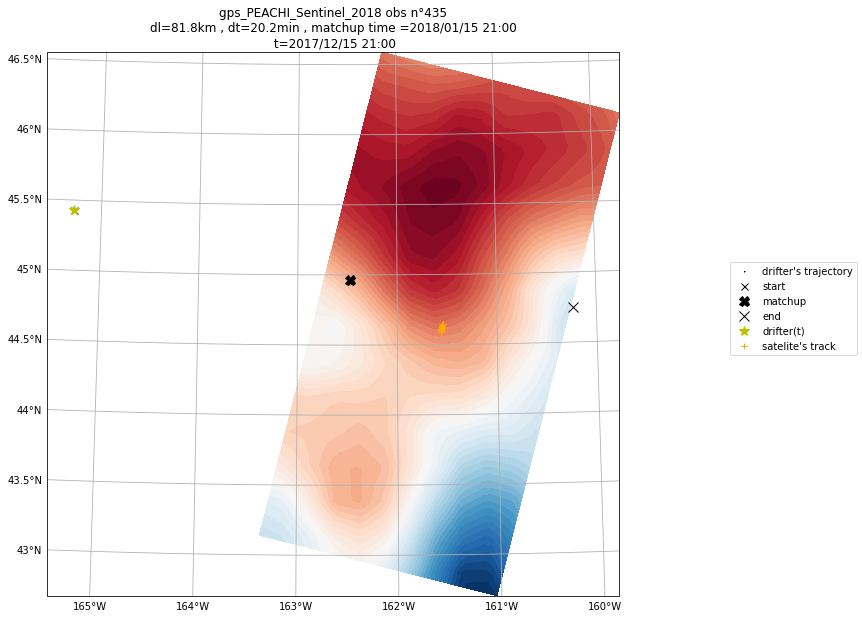

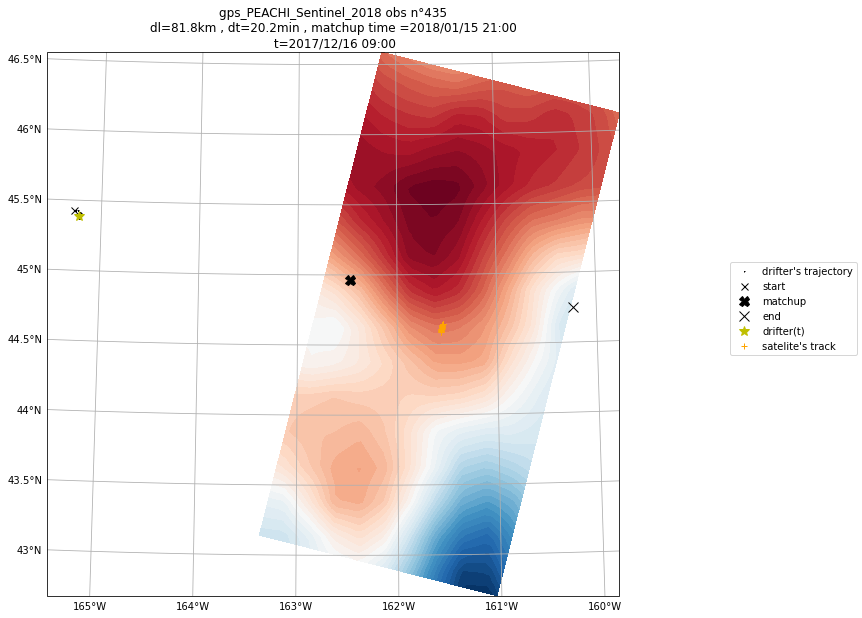

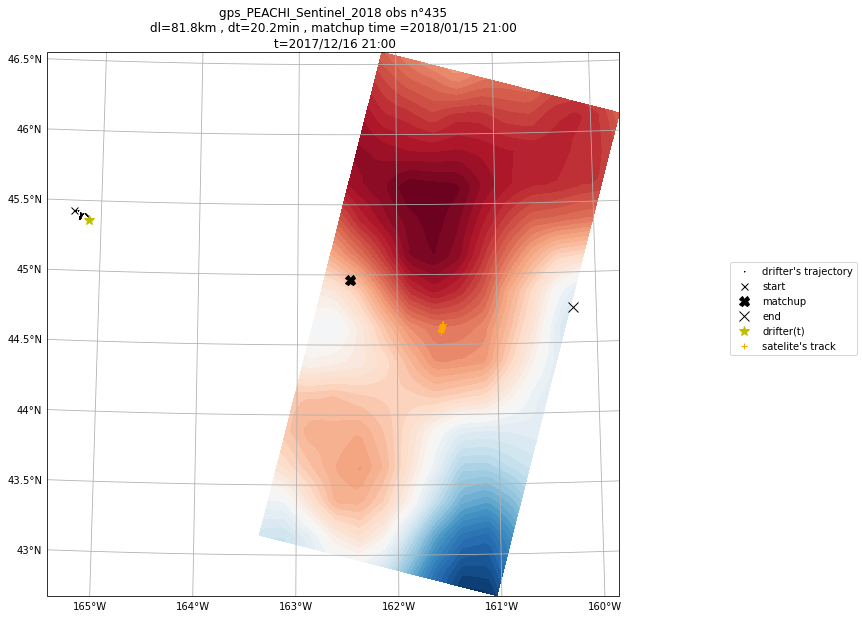

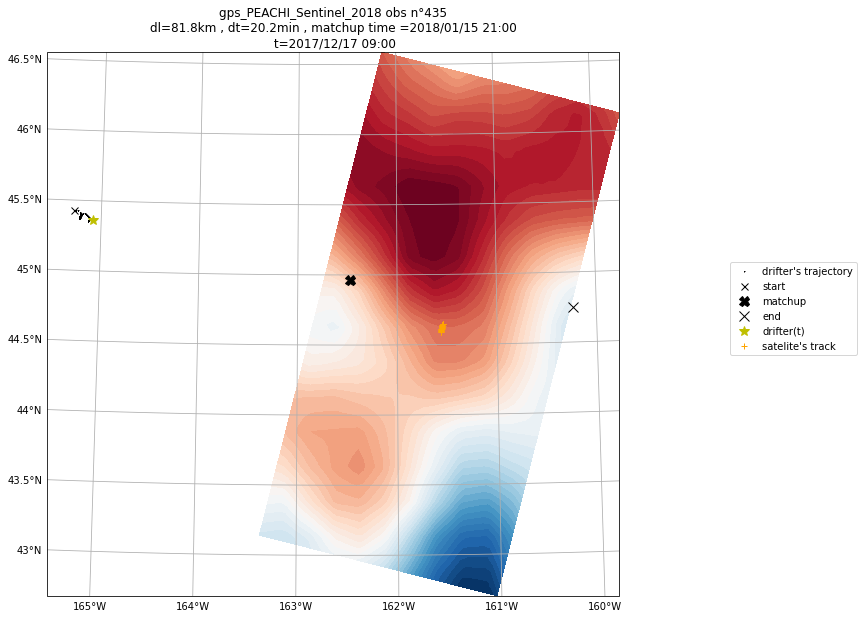

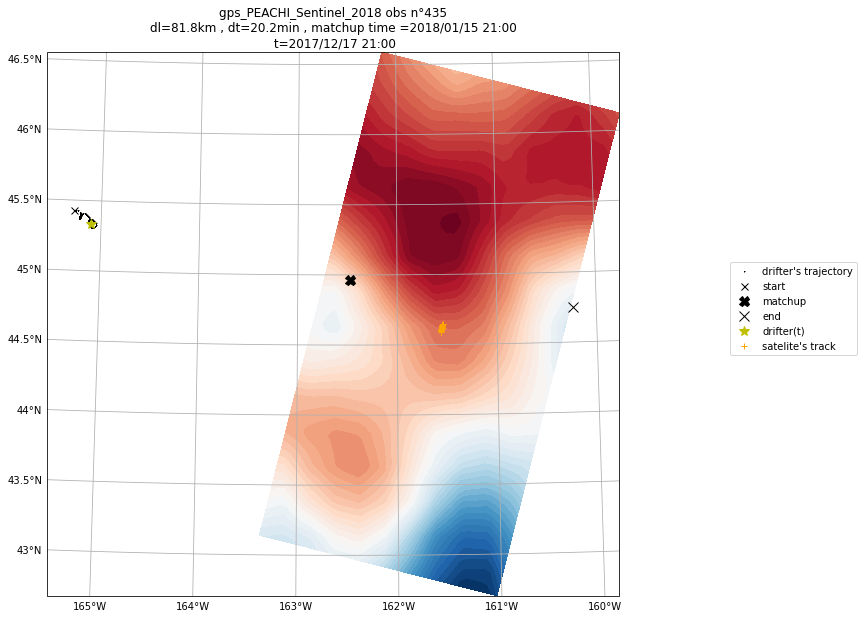

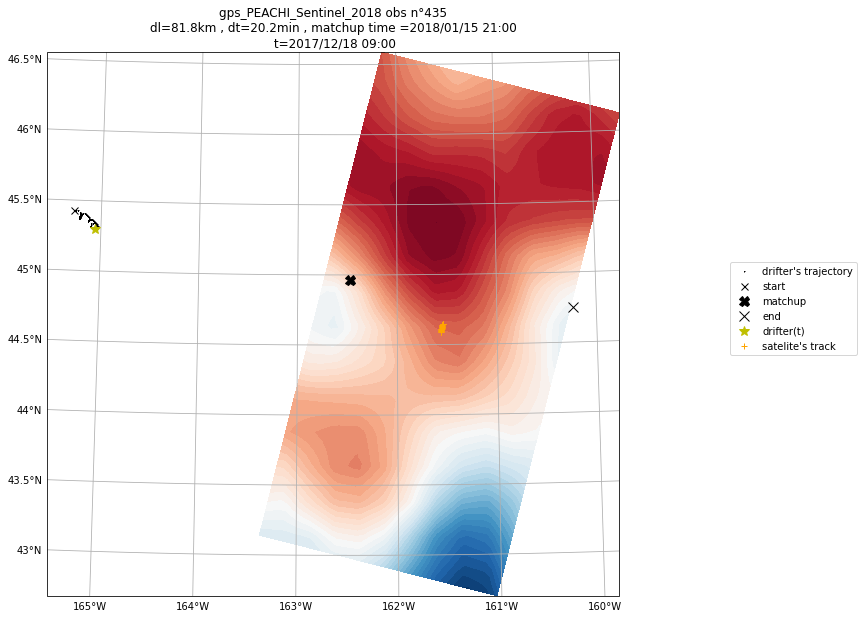

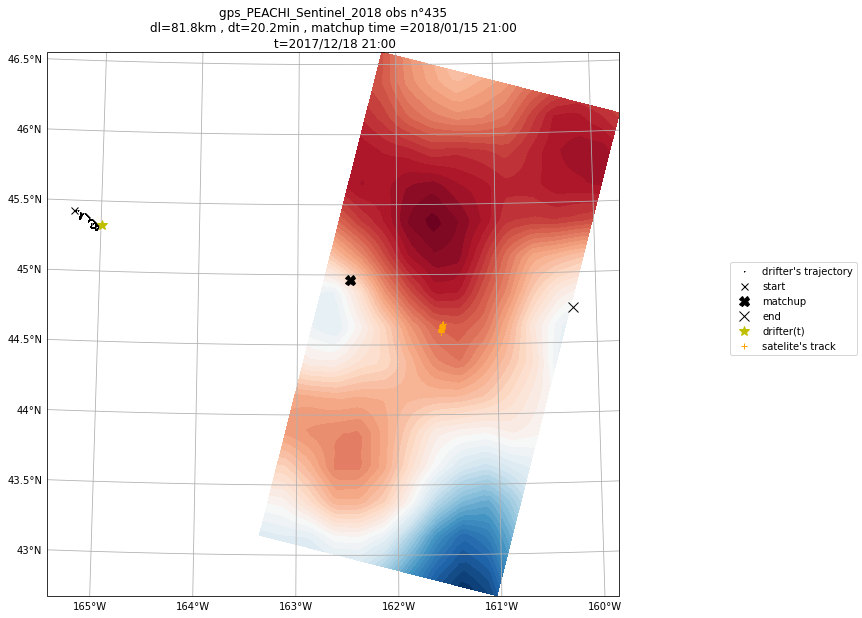

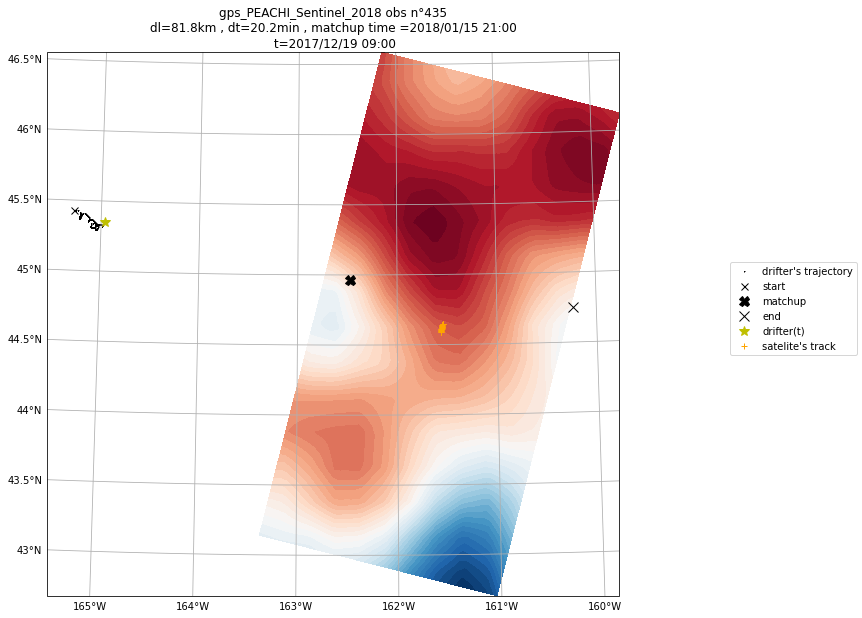

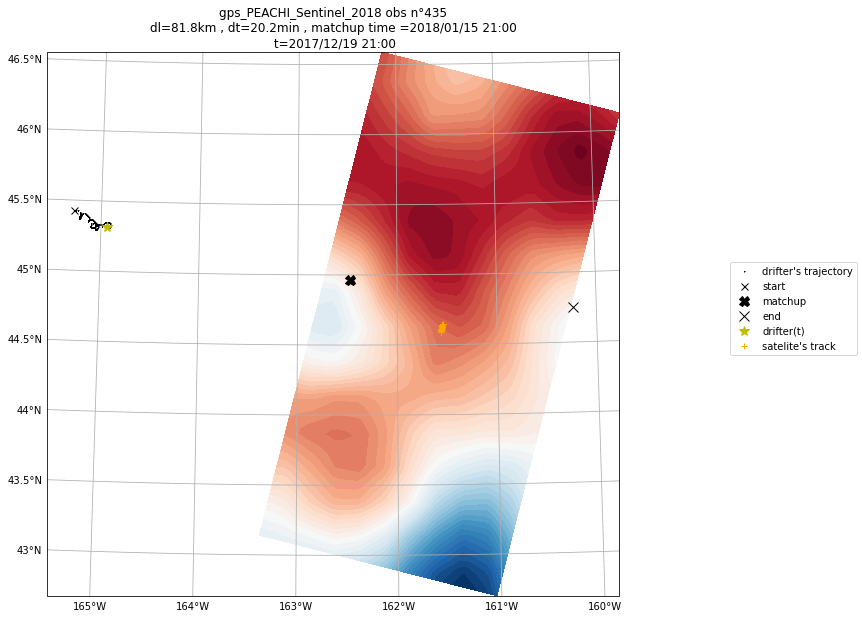

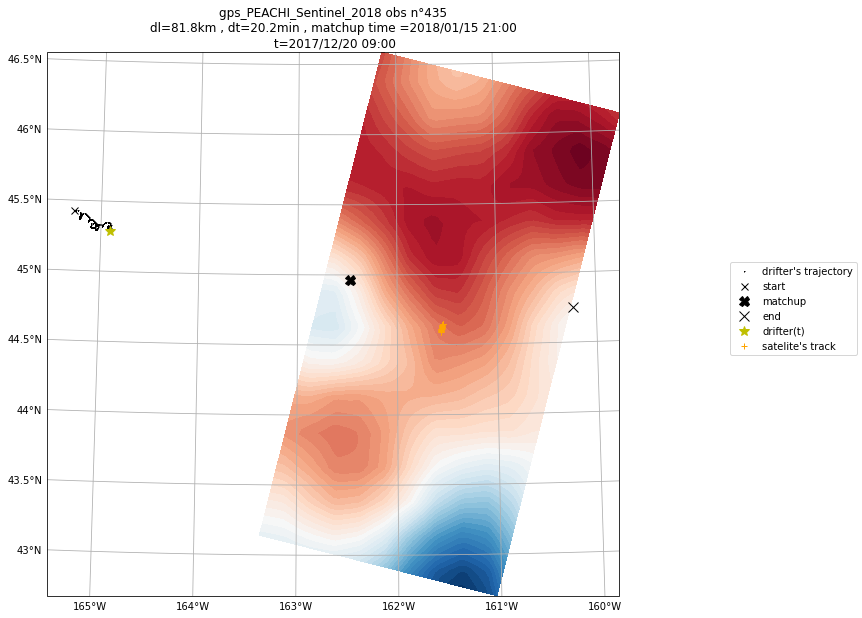

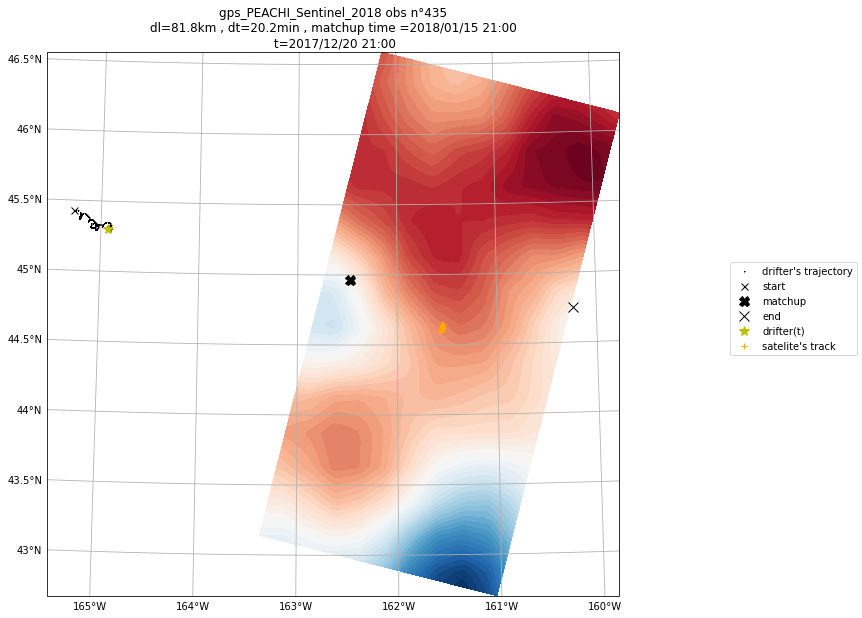

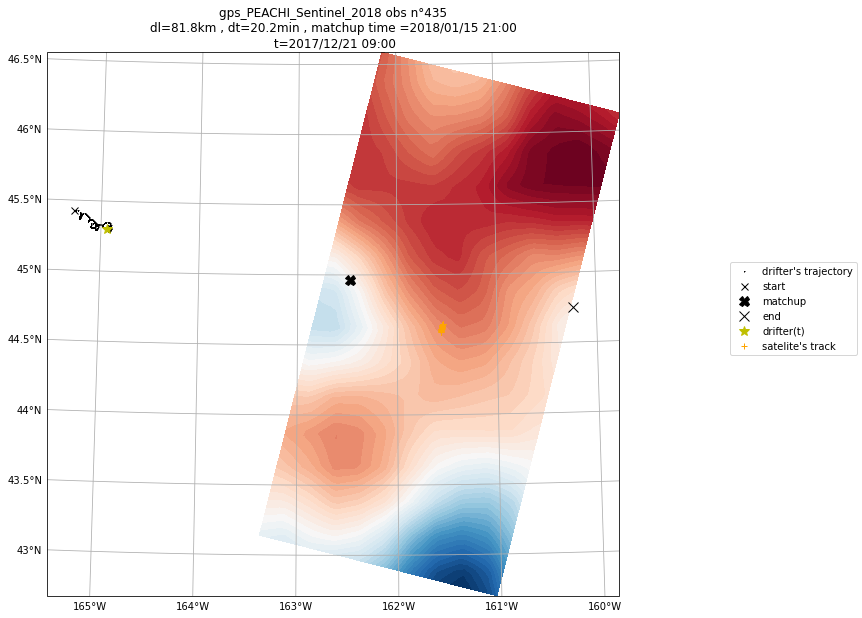

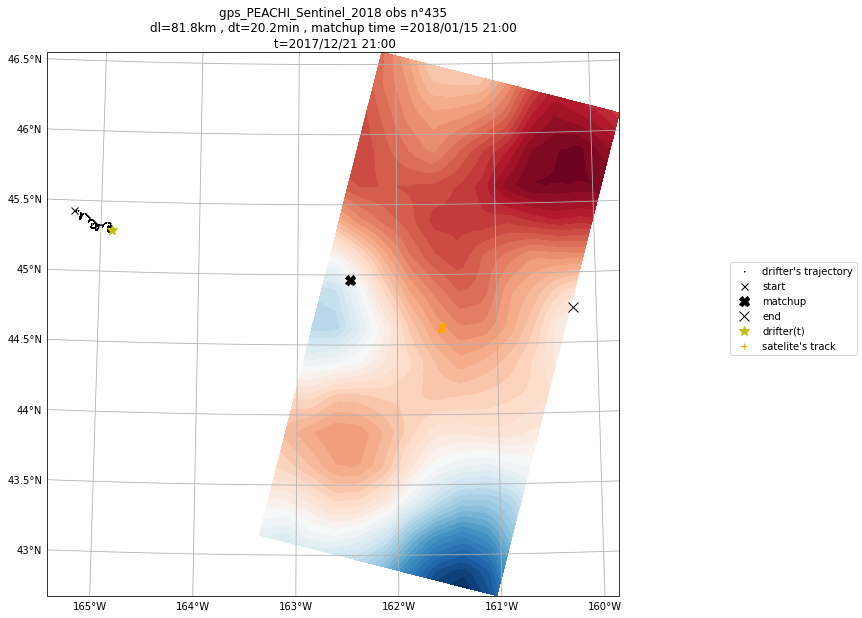

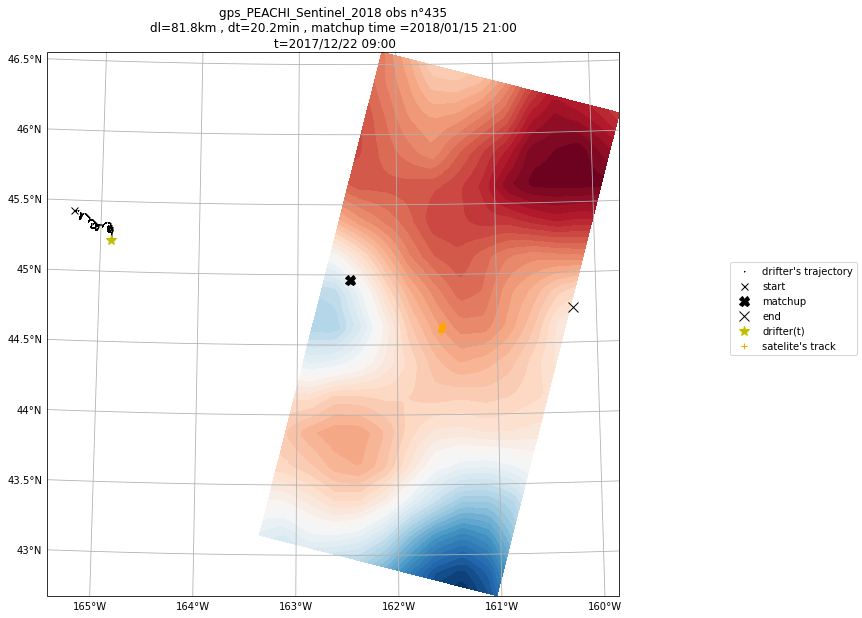

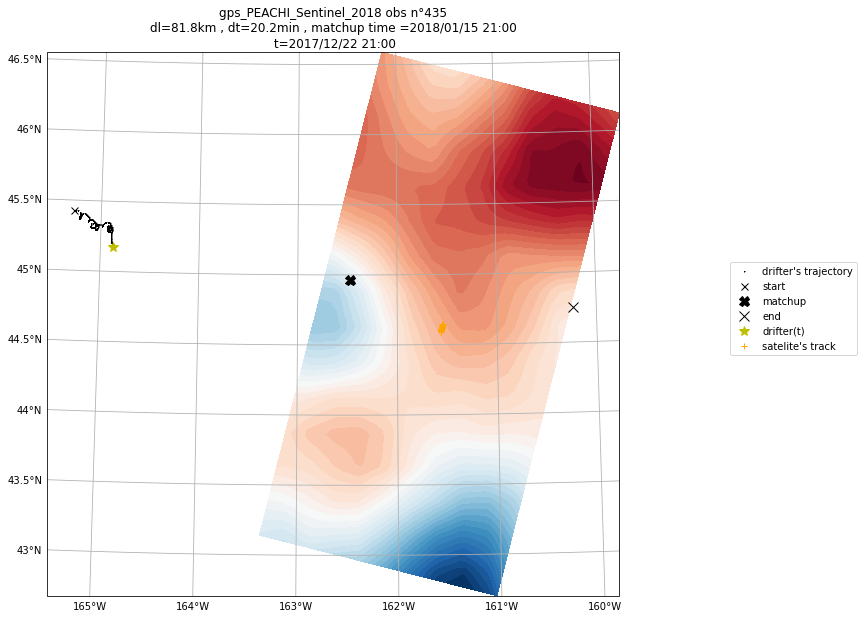

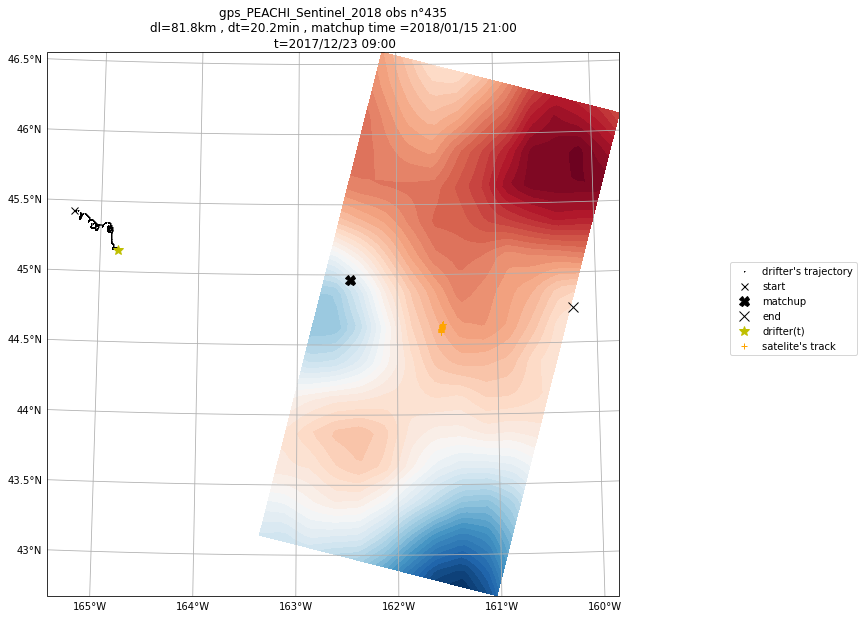

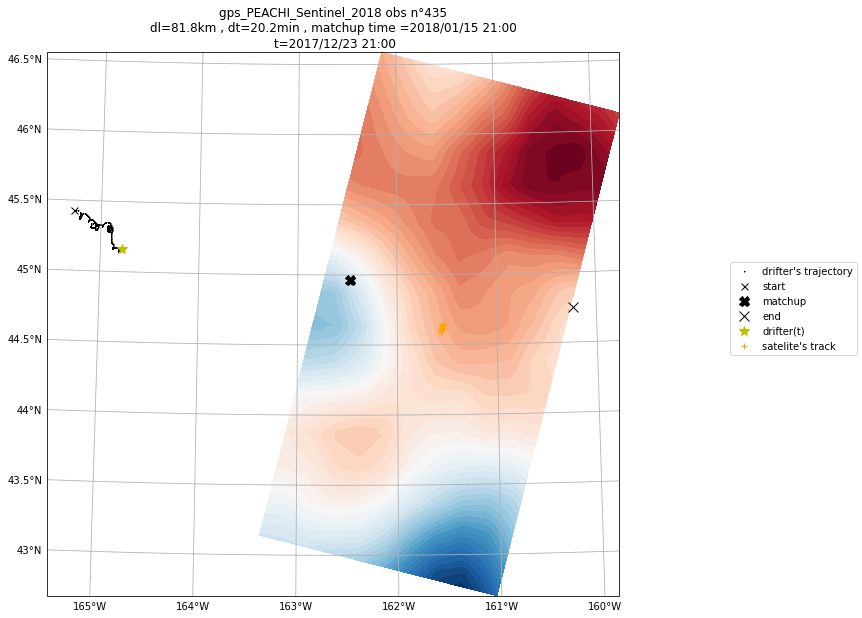

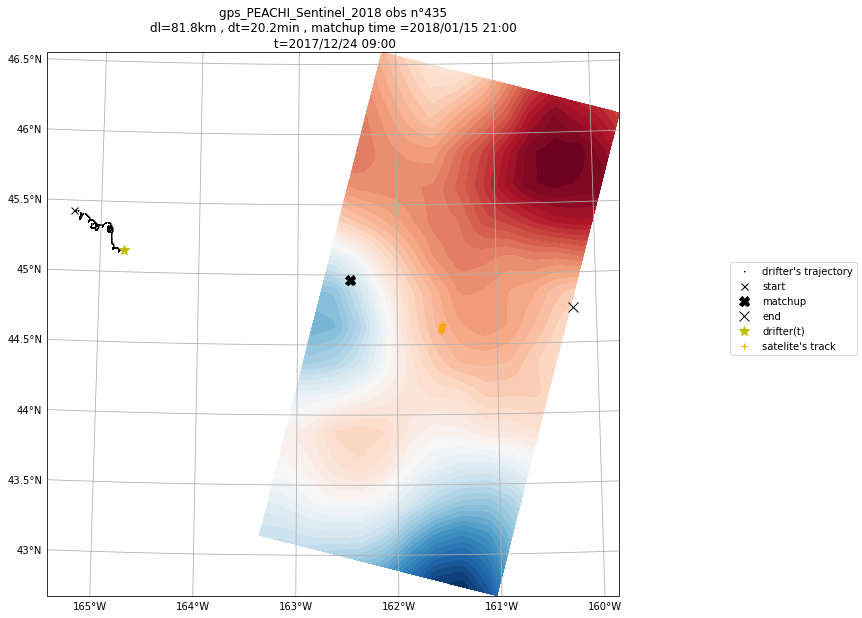

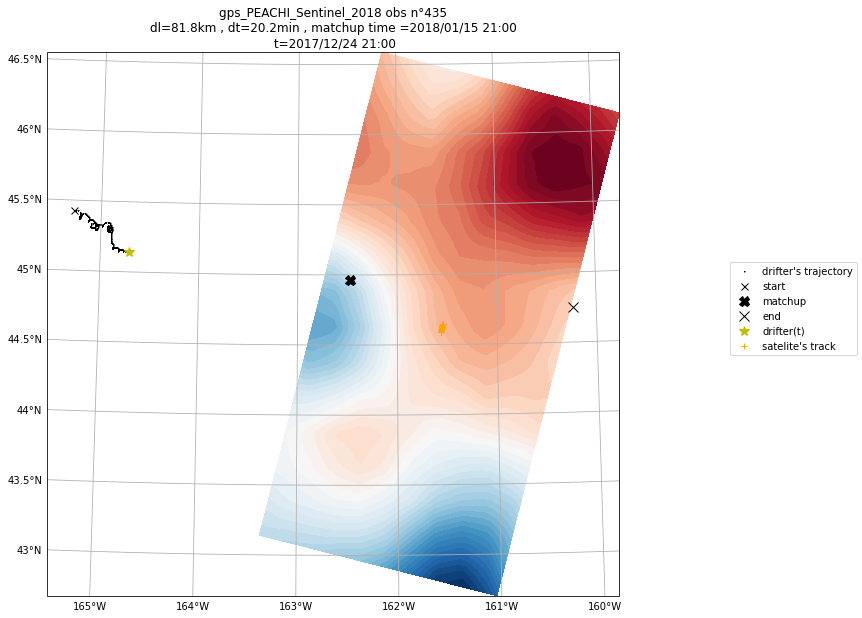

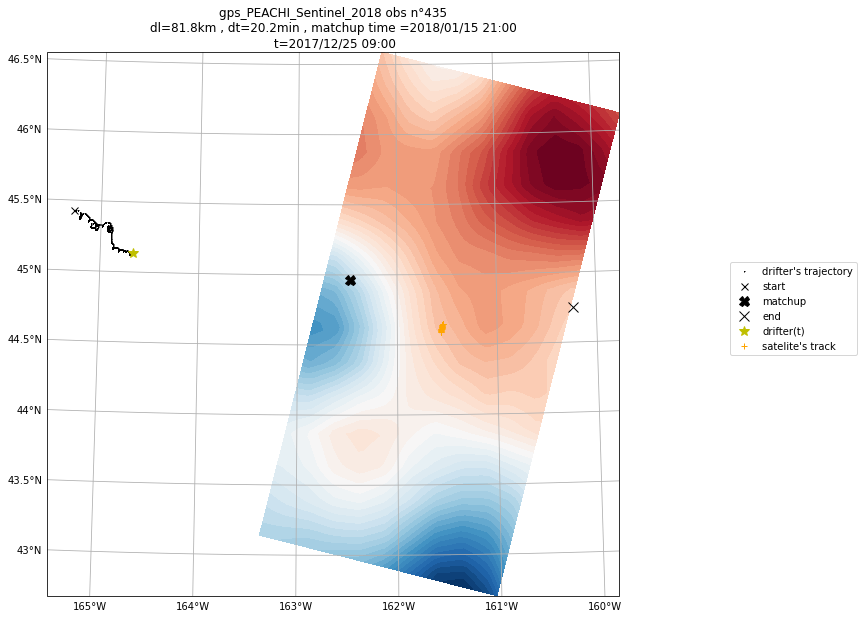

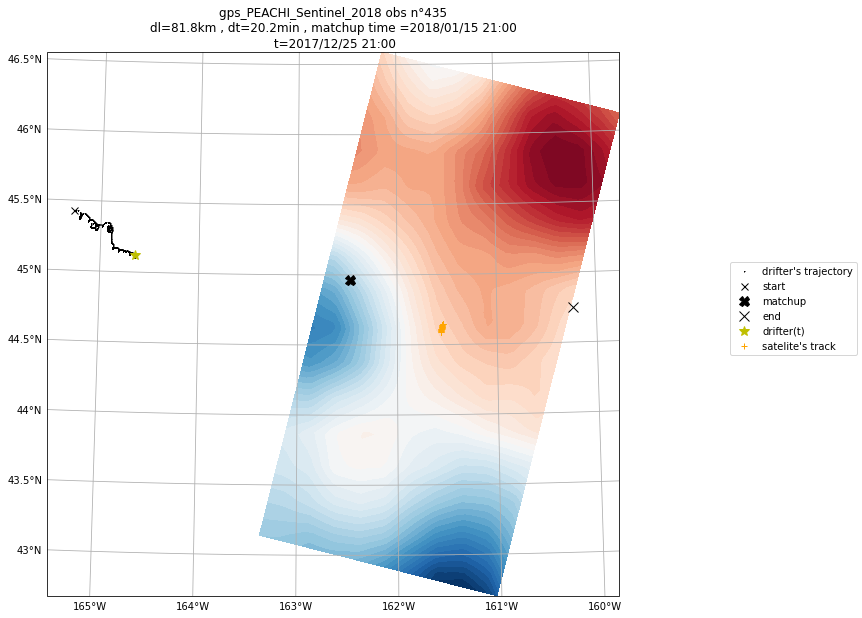

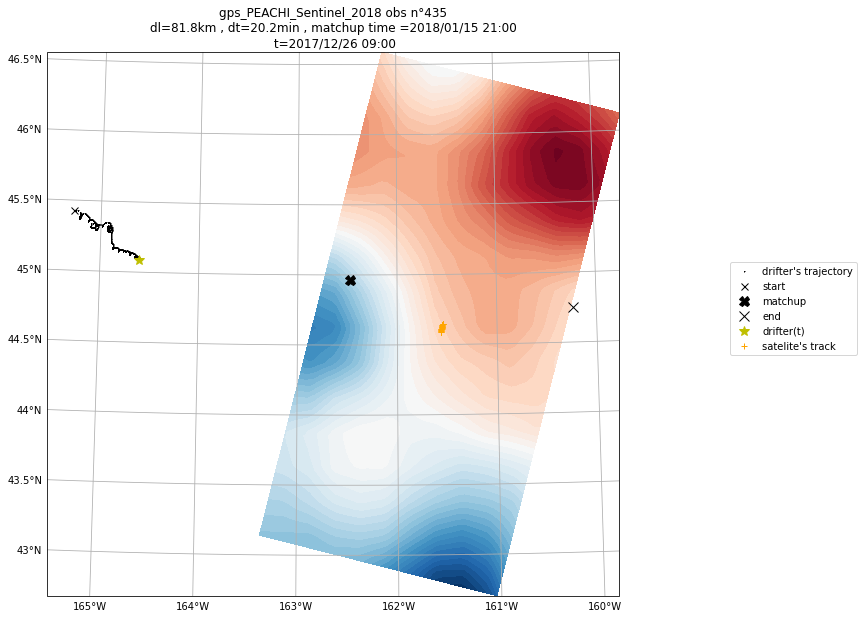

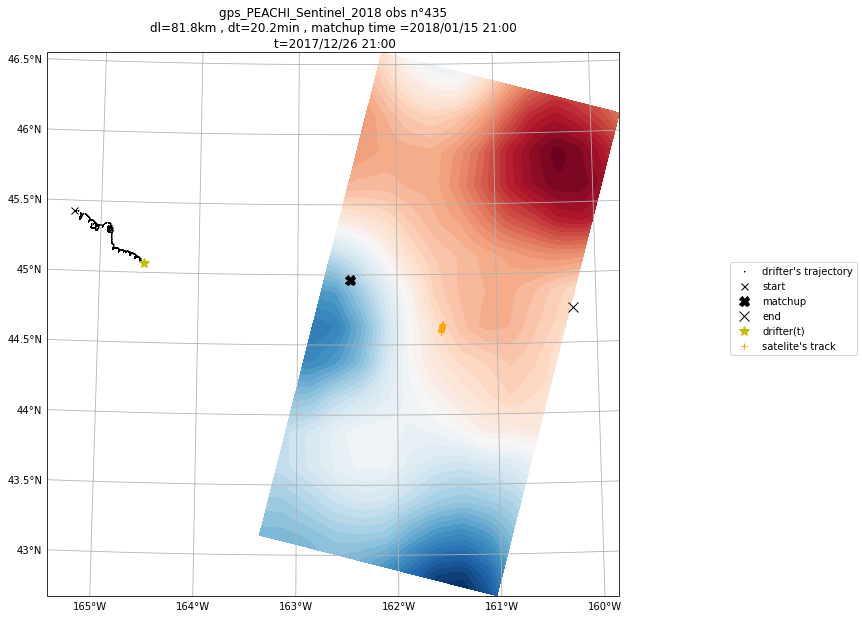

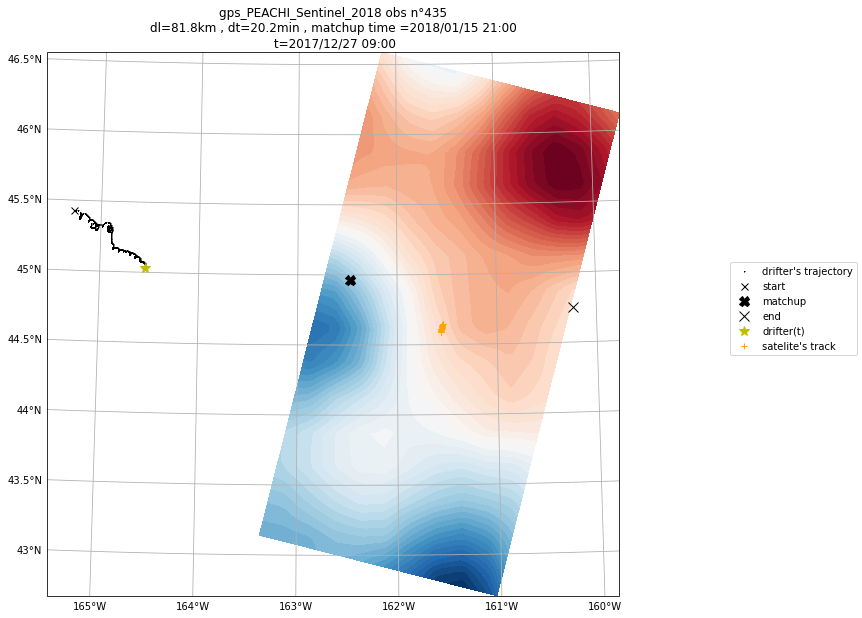

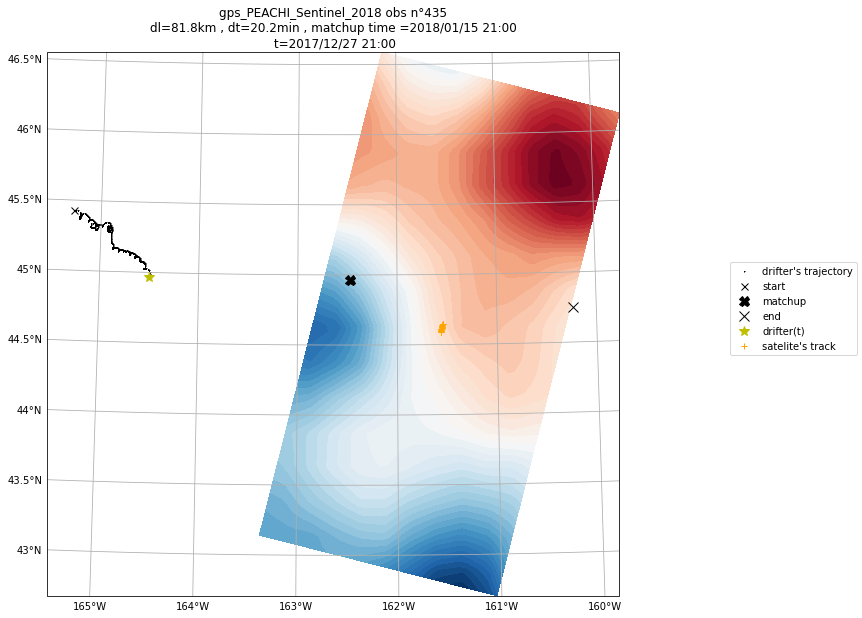

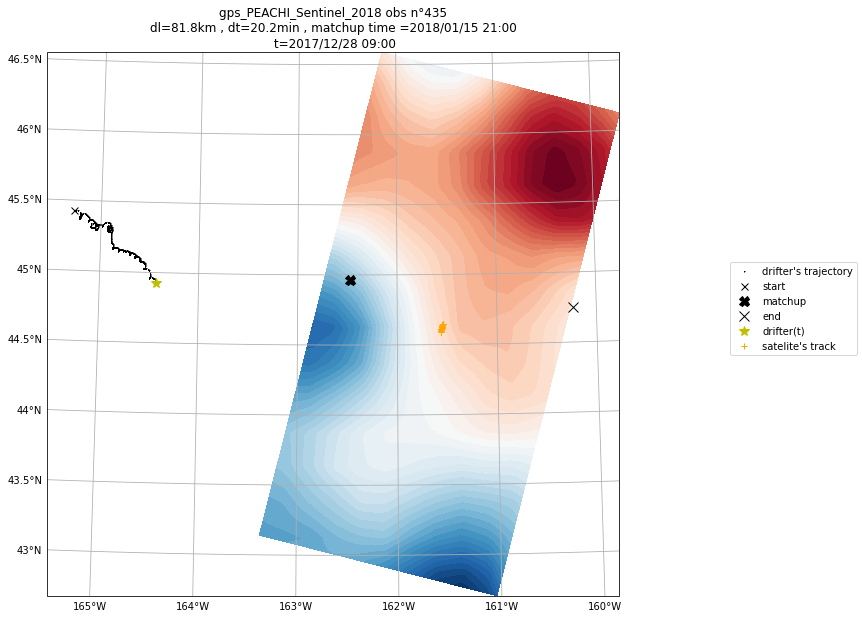

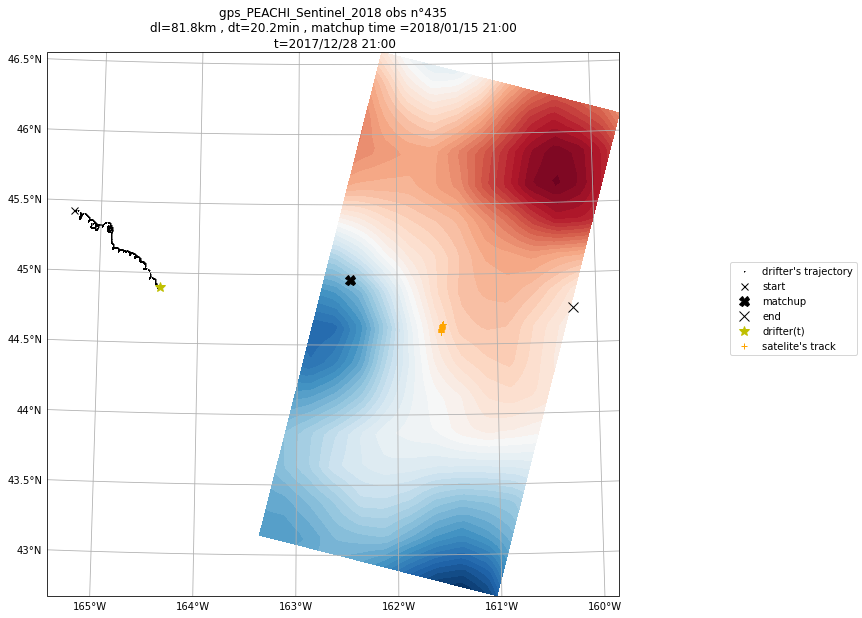

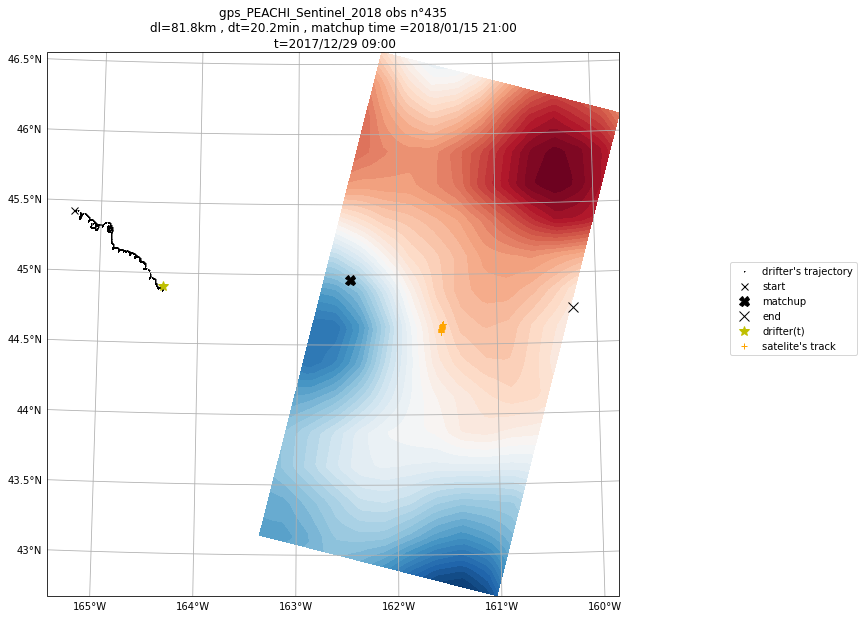

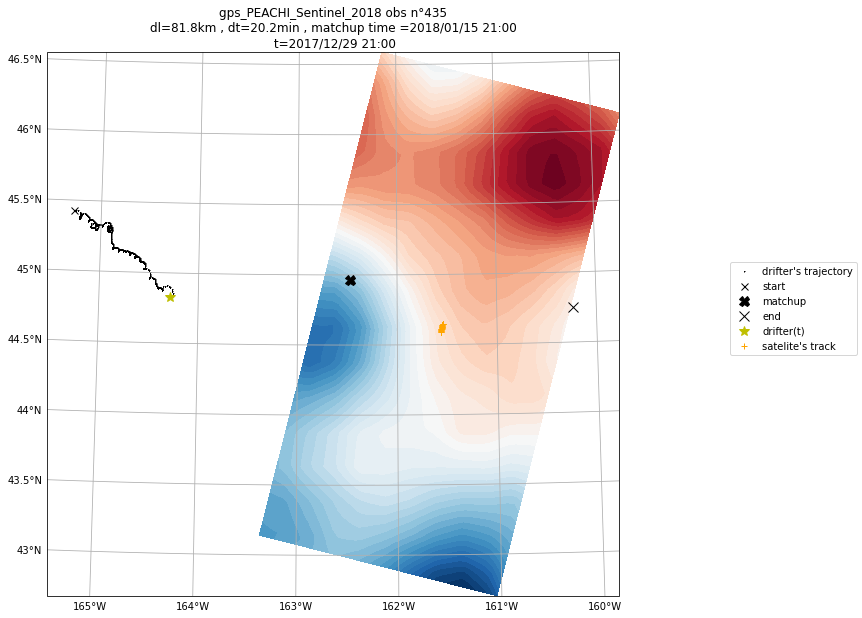

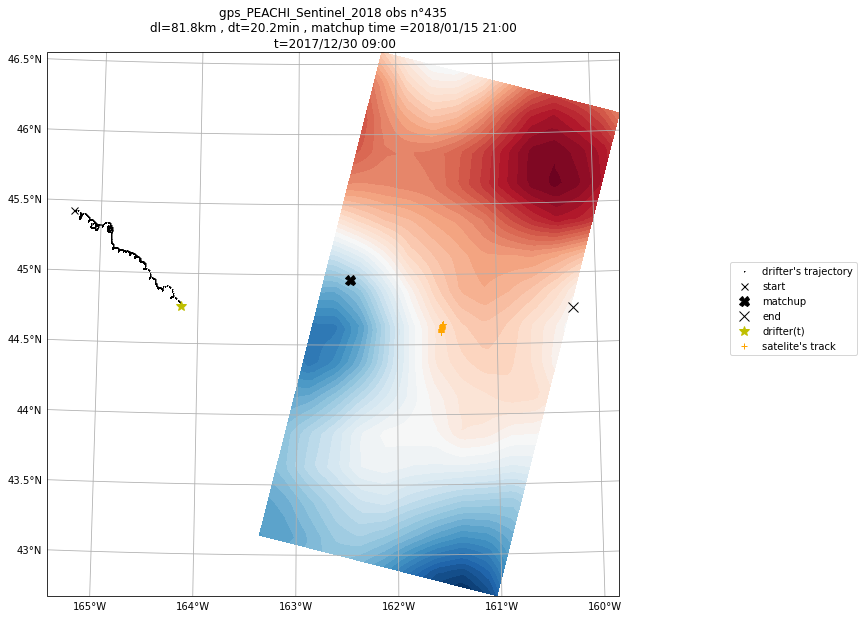

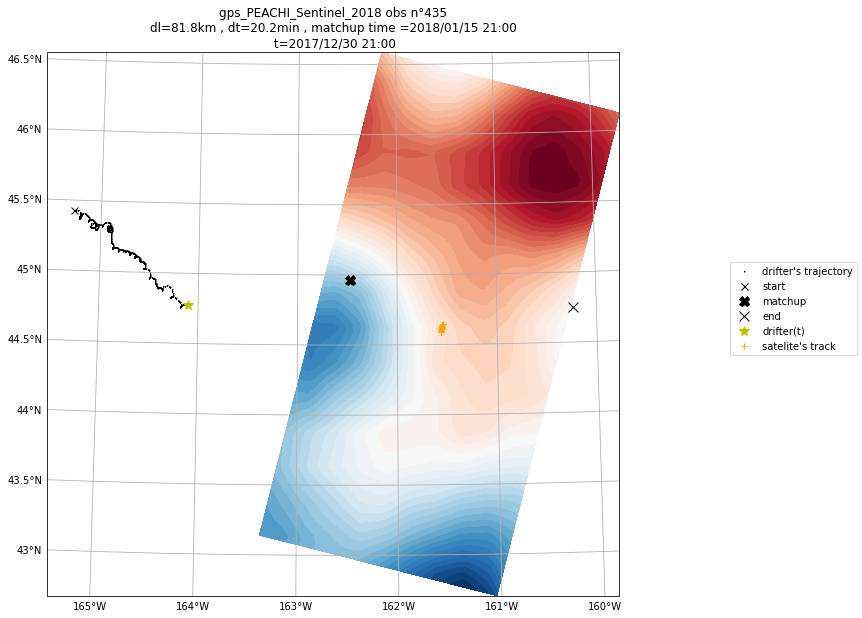

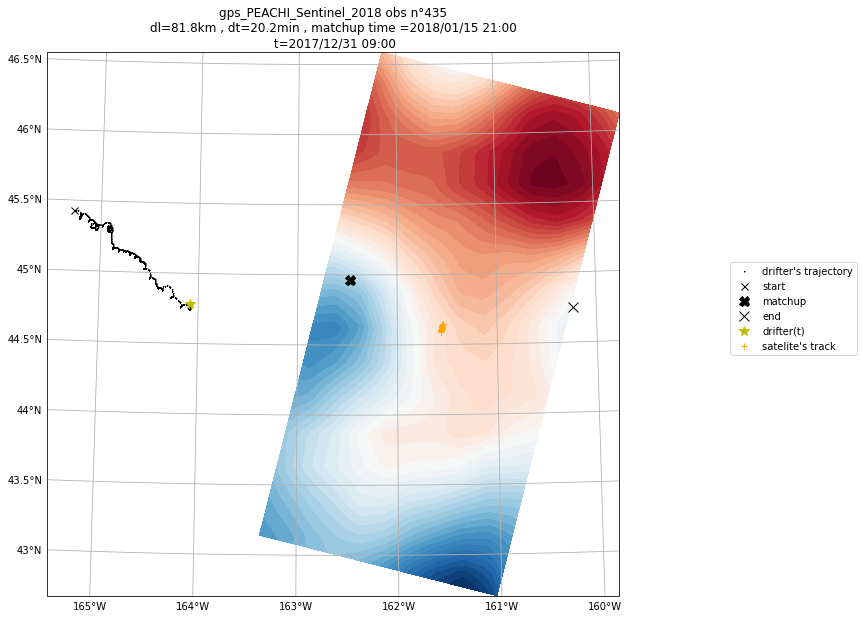

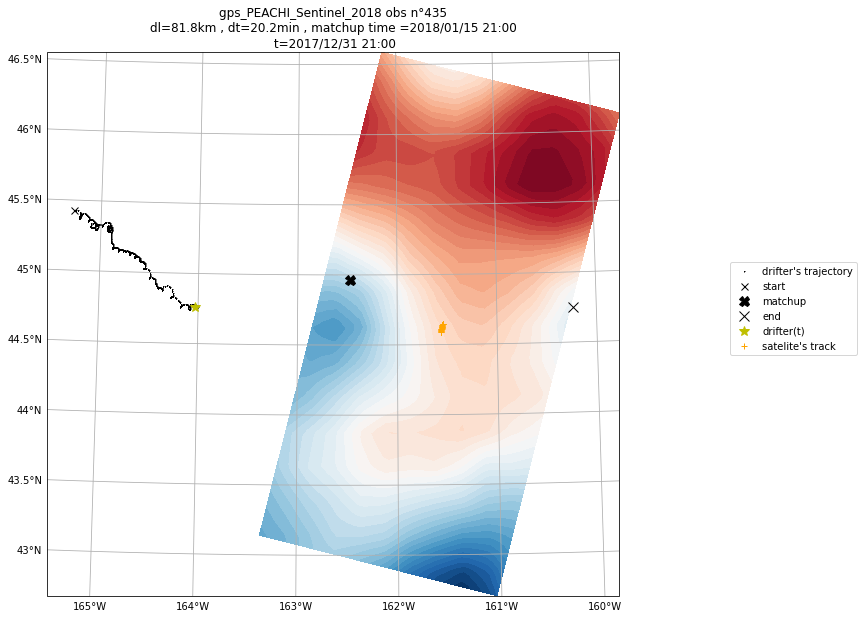

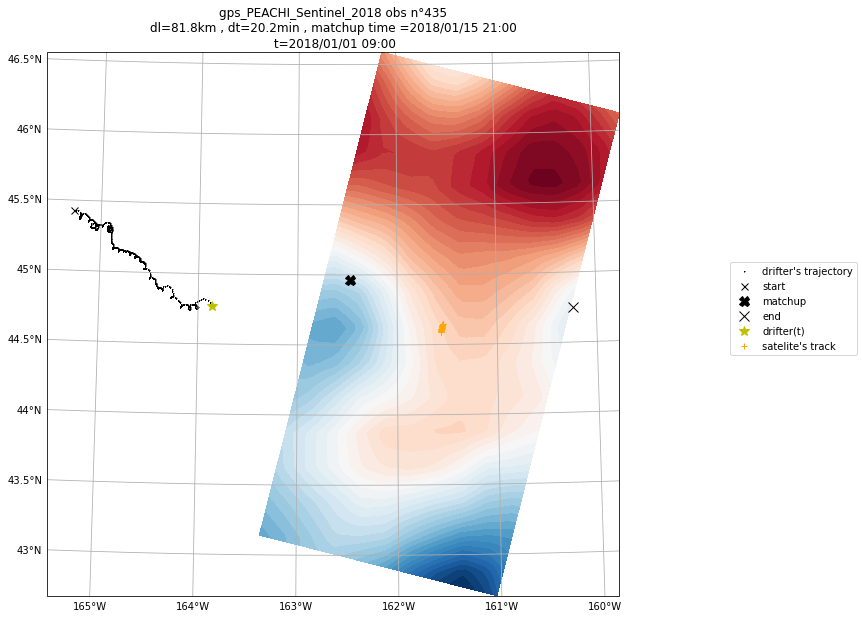

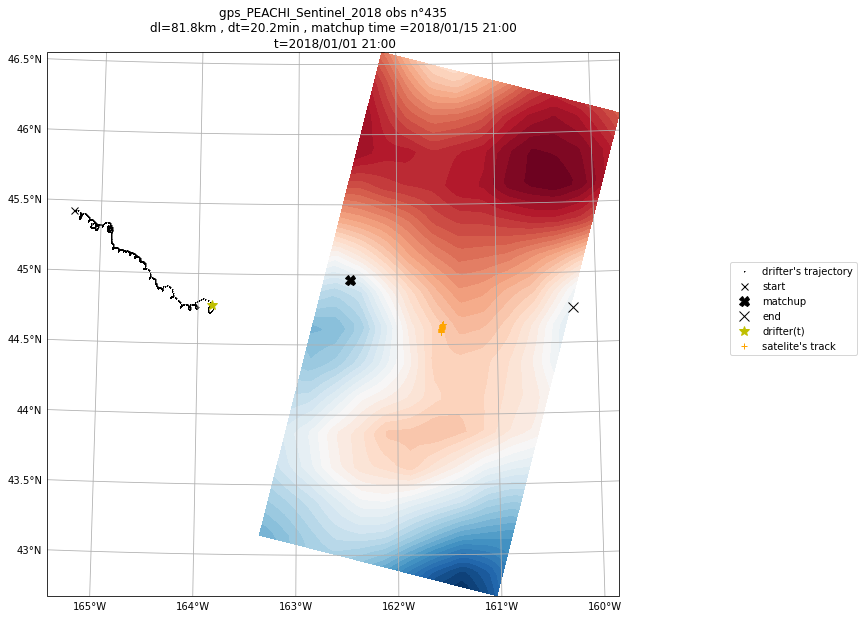

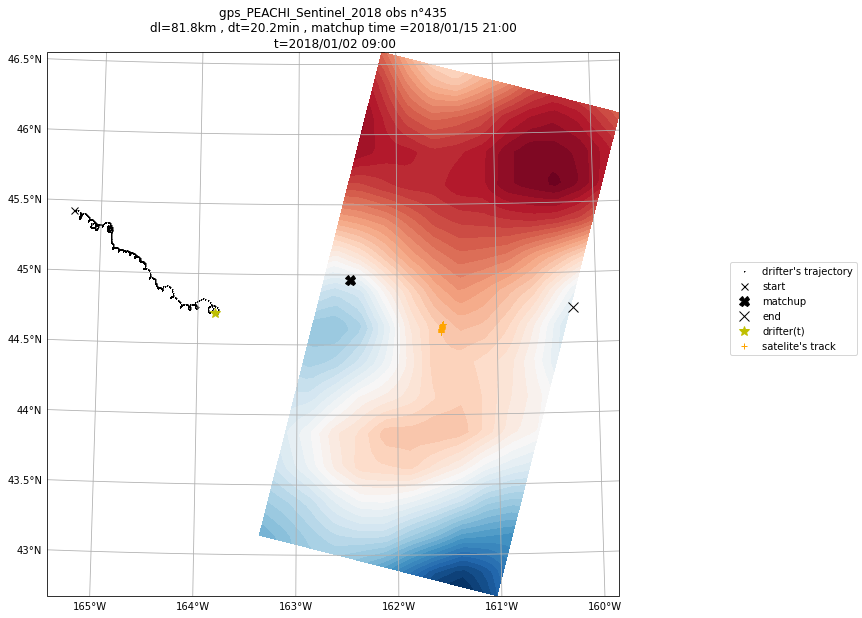

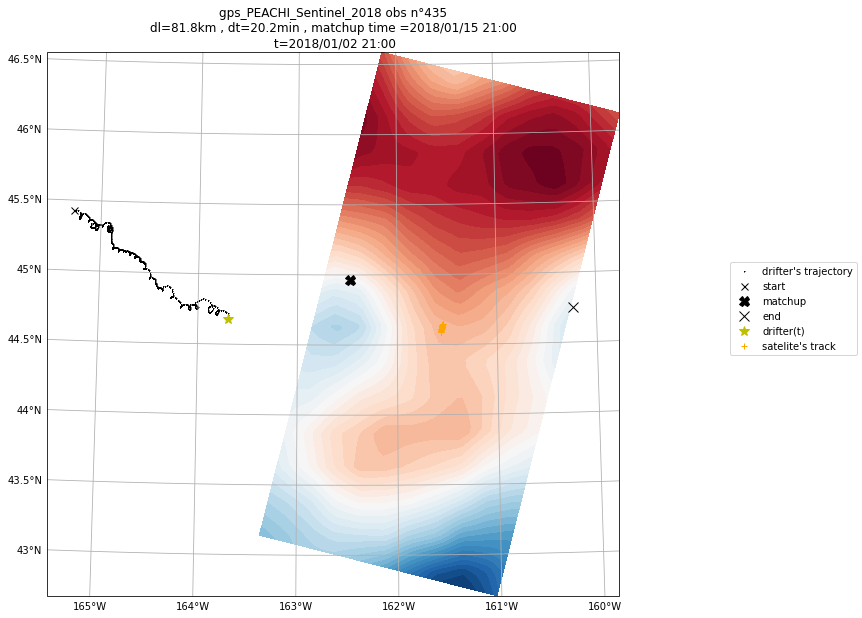

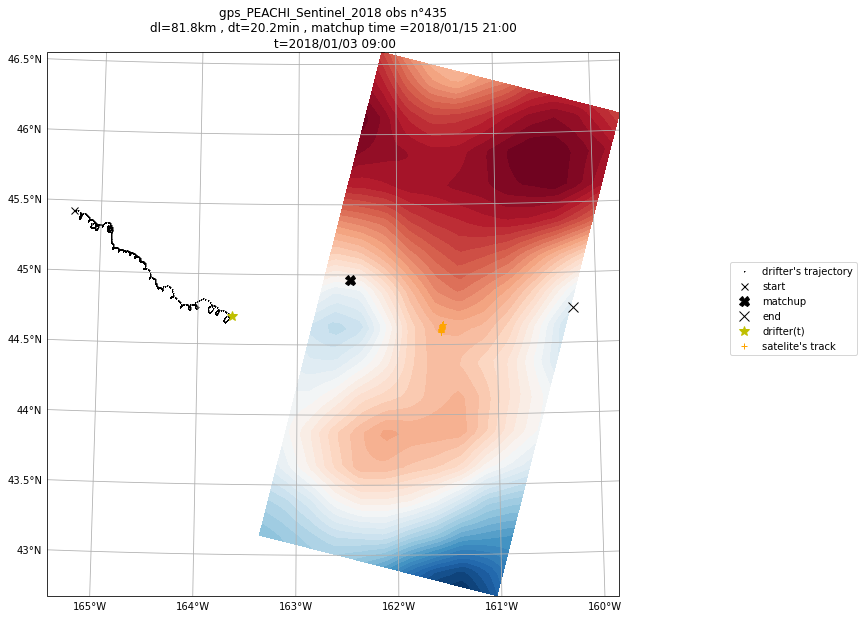

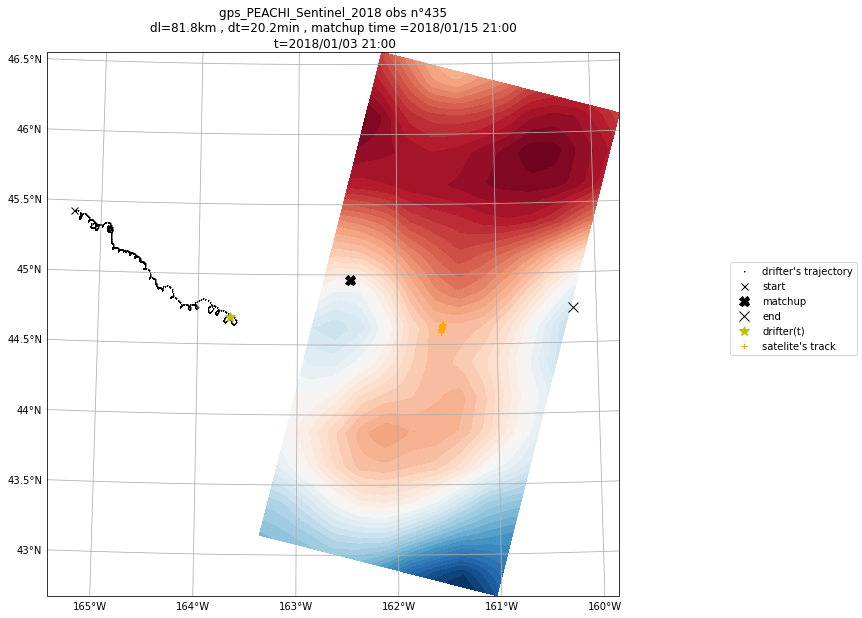

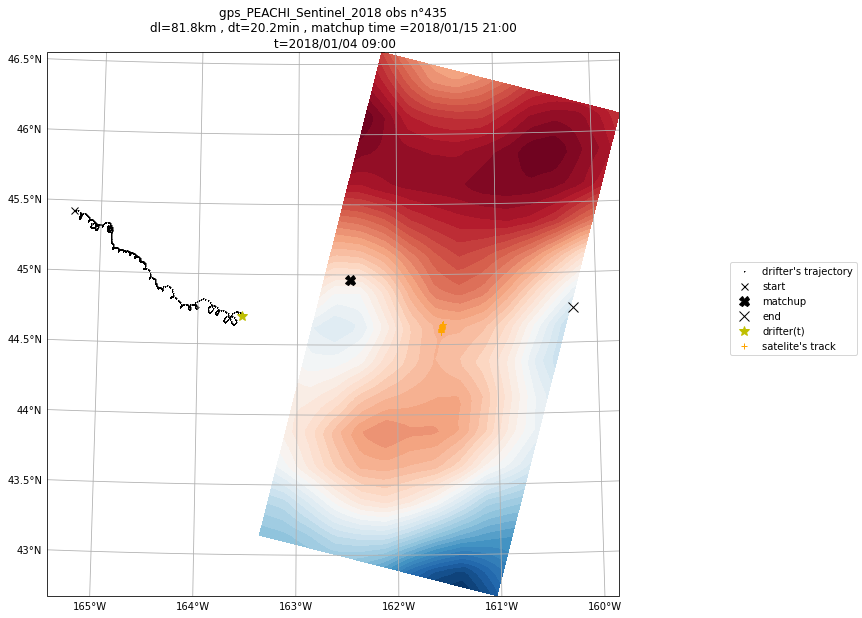

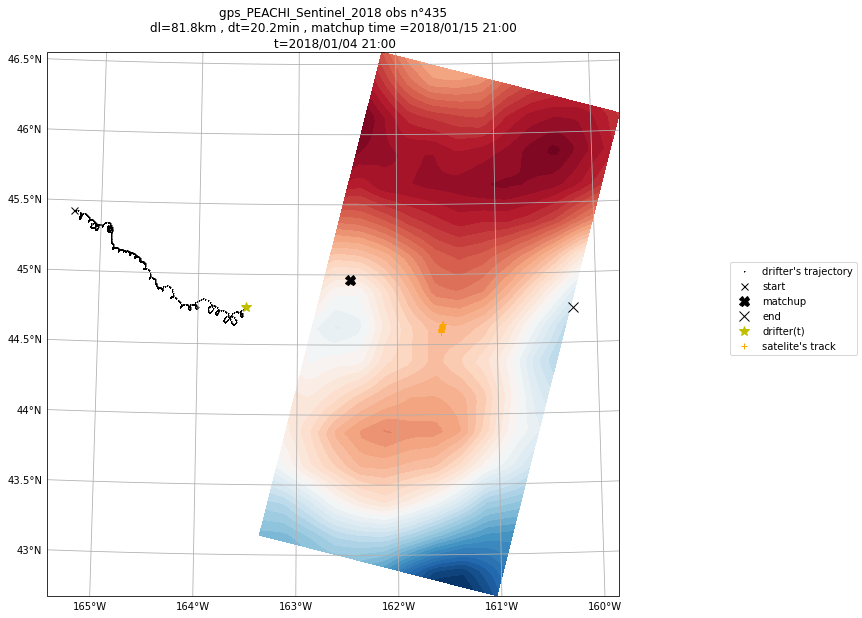

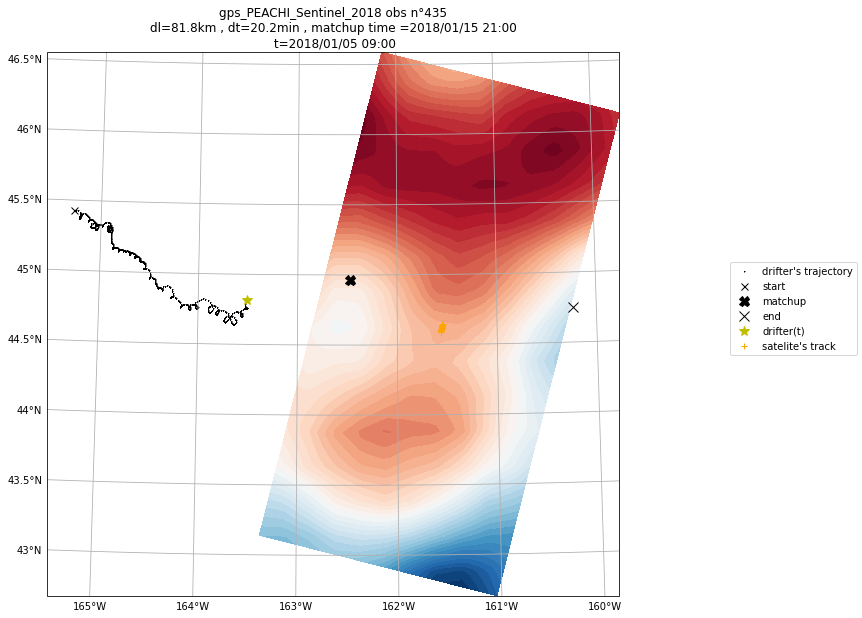

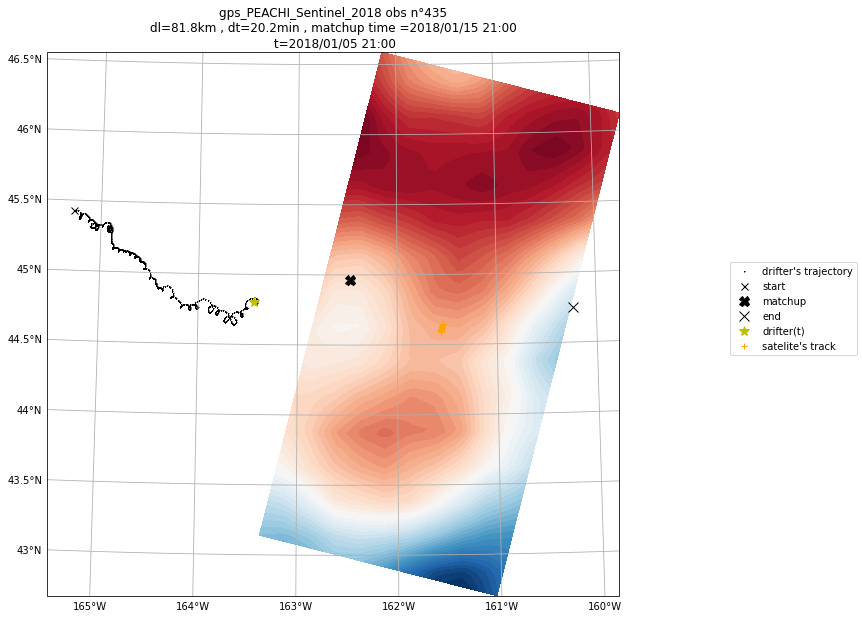

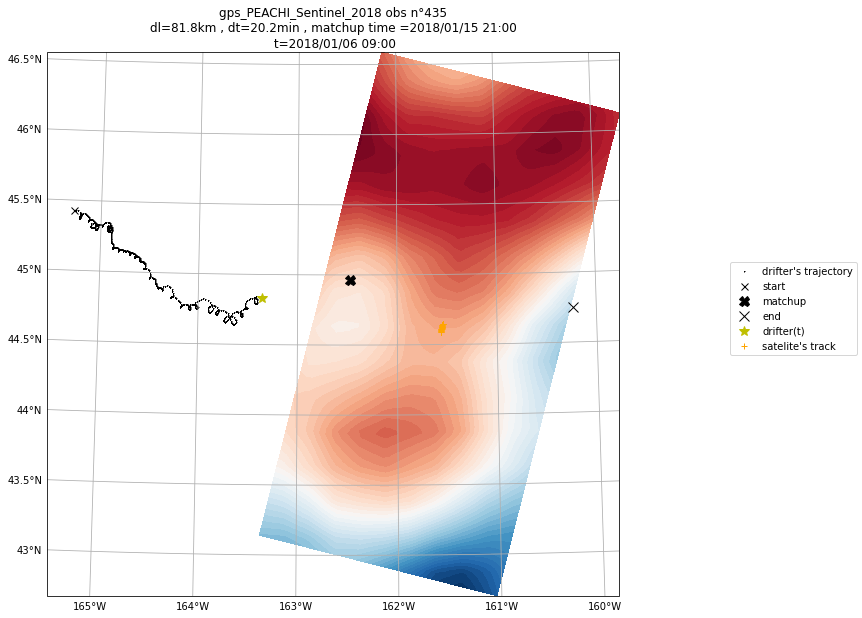

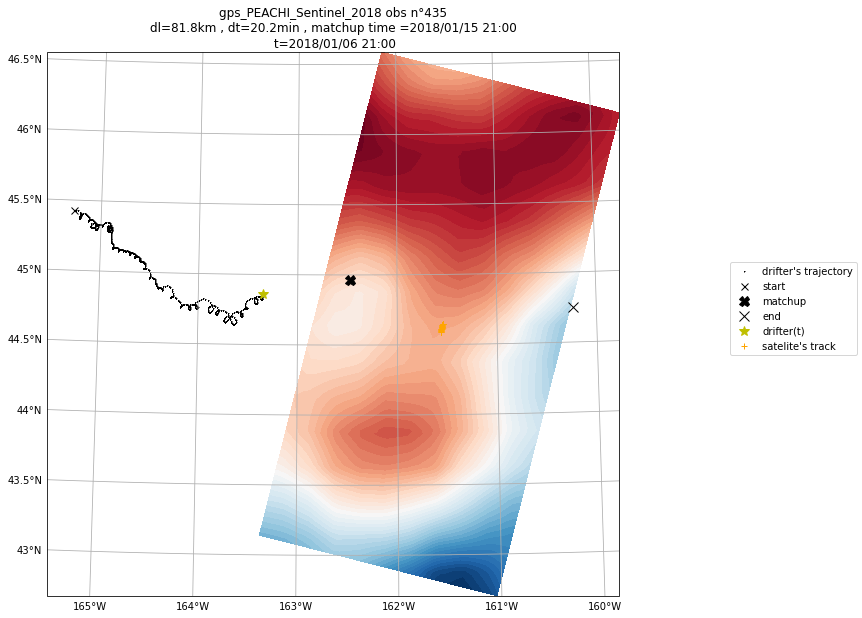

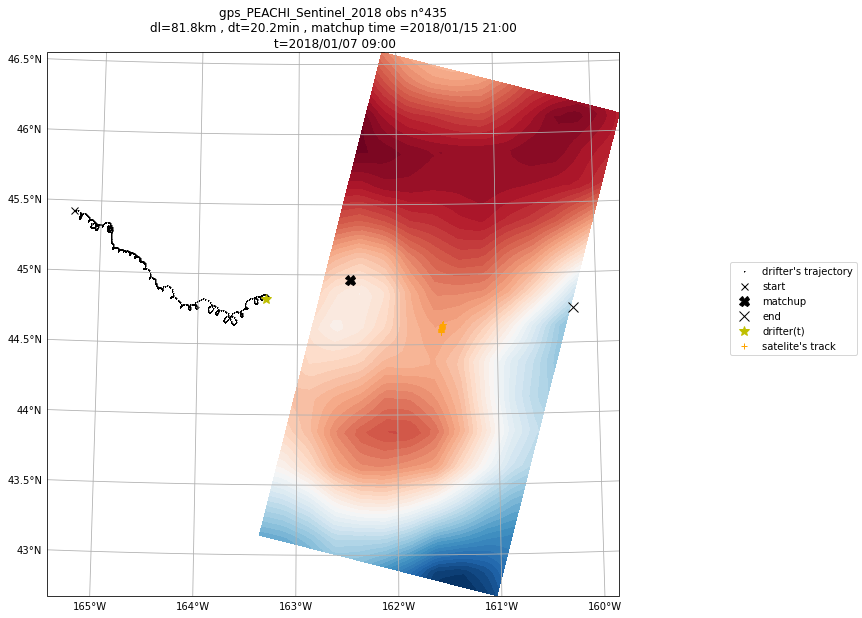

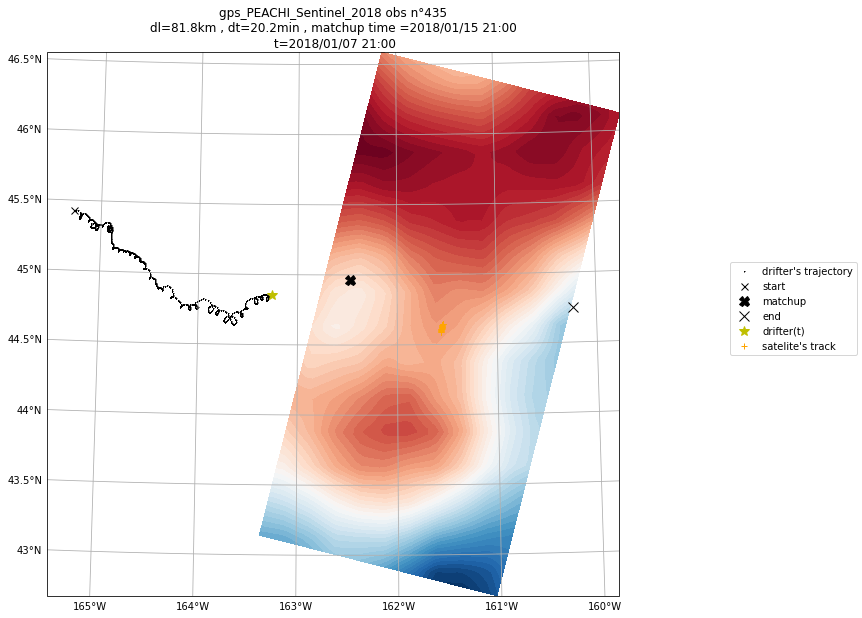

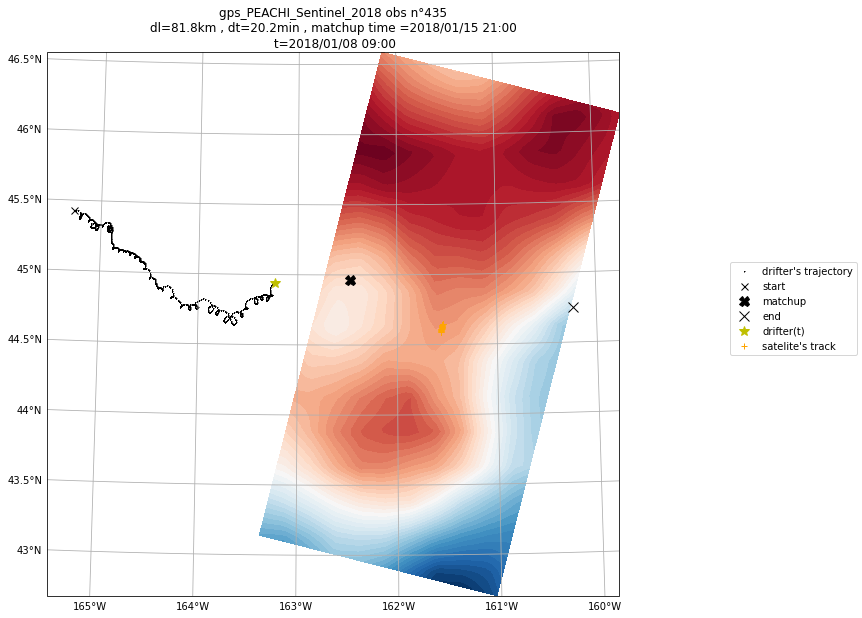

In [ ]:
for time_indice in range(0, len(do.drifter_time.values), 12):    
    fig = plt.figure(figsize=(15,10))
    fig.patch.set_facecolor('white')#no transparancy in png
    aviso_traj_map(do, time_indice)    
    fig.legend(loc='center right')
    fig.savefig(f"{path}/t_{time_indice}.png")

# Creating GIF

In [55]:
import glob
from PIL import Image
def make_gif(frame_folder,duration = 200):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(f'{frame_folder}.gif', format="GIF", append_images=frames,
               save_all=True, duration=duration, loop=0)

In [56]:
make_gif(path)

# See trajectory in the box, with arrows for acceleration + values ?

In [168]:
do

<xarray.Dataset>
Dimensions:                                (drifter_time: 1489, alti_time: 21,
                                            sassa_meas_ind_wv: 128,
                                            alti_time_mid: 20, box_y: 40,
                                            box_x: 80)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            (drifter_time) datetime64[ns] 2017...
    es_time_                               (drifter_time) datetime64[ns] 2017...
  * drifter_time                           (drifter_time) datetime64[ns] 2017...
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/120)
    __site_id                              object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice                  int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                            object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_y                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    alti___distance                        float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                                     ...
    es_cstrio_z0_drifter_wd_n              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_e                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_n                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_box_wd_e                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_n                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    drifter_typebuoy                       (drifter_time) object dask.array<chunksize=(94,), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [171]:
do_box= do
#do_box = do_box.where(do_box.drifter_y>-100e3,drop=True)
#do_box = do_box.where(do_box.drifter_x<200e3, drop=True)
#do_box = do_box.where(do_box.drifter_y>-200e3, drop=True)
#do_box=do_box.where(do_box.drifter_x>-200e3)

In [170]:
do_box

<xarray.Dataset>
Dimensions:                                (drifter_time: 1489, alti_time: 21,
                                            sassa_meas_ind_wv: 128, box_y: 40,
                                            box_x: 80, alti_time_mid: 20)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            (drifter_time) datetime64[ns] 2017...
    es_time_                               (drifter_time) datetime64[ns] 2017...
  * drifter_time                           (drifter_time) datetime64[ns] 2017...
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/120)
    __site_id                              (drifter_time) object dask.array<chunksize=(1489,), meta=np.ndarray>
    __site_matchup_indice                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    __site_name                            (drifter_time) object dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_x                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    acc_y                                  (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    alti___distance                        (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    ...                                     ...
    es_cstrio_z0_drifter_wd_n              (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_e                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_traj_wd_n                 (drifter_time) float64 dask.array<chunksize=(1489,), meta=np.ndarray>
    es_cstrio_z0_box_wd_e                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    es_cstrio_z0_box_wd_n                  (drifter_time, box_y, box_x) float64 dask.array<chunksize=(1489, 40, 80), meta=np.ndarray>
    drifter_typebuoy                       (drifter_time) object dask.array<chunksize=(94,), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

Text(0.5, 1.0, 'dl=81.8km , dt=20.2min , matchup time =2018/01/15 21:00\n t=2018/01/15 22:00')

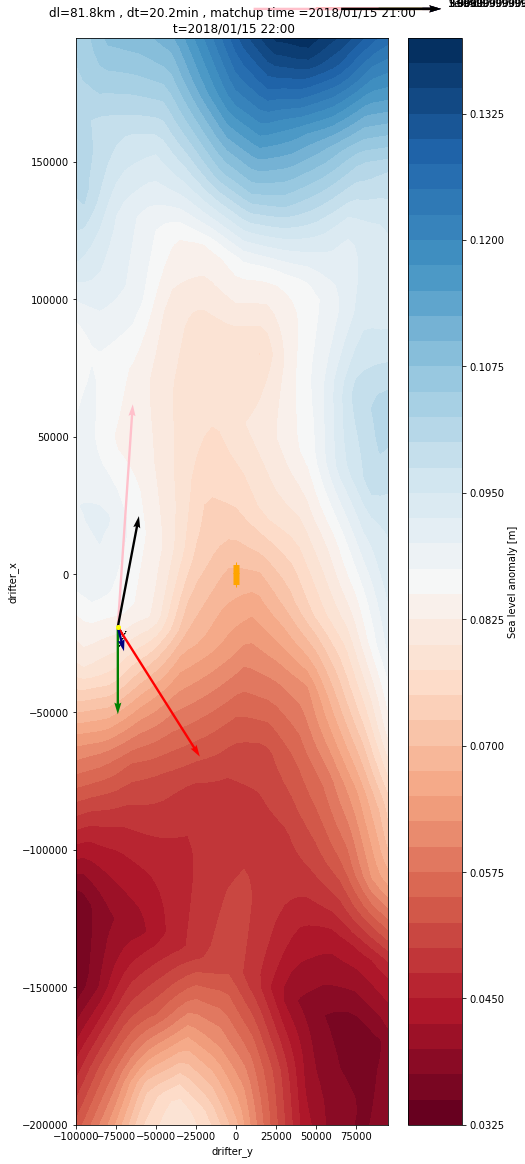

In [180]:
fig = plt.figure(figsize=(7,20))
it=777


lon, lat, t = float(do_box.lon), float(do_box.lat), do.time.values
id_matchup = int(do_box.__site_matchup_indice.values)
td = pd.to_datetime(t)
dt = float(do_box["alti___time_difference"])
dl = float(do_box["alti___distance"])
    
do_bt = do_box.isel(drifter_time = it)
do_bt['sum_x'] = do_bt['coriolis_x']+do_bt['es_cstrio_z0_drifter_wd_x']+do_bt['aviso_traj_g_grad_x']
do_bt['sum_y'] = do_bt['coriolis_y']+do_bt['es_cstrio_z0_drifter_wd_y']+do_bt['aviso_traj_g_grad_y']

t = pd.to_datetime(do_t.drifter_time.values)
ax = fig.add_subplot(111)

#AVISO
#ax.contourf( do_t.box_y, do_t.box_x, do_t.aviso_sla.transpose(), levels=30, cmap='viridis', label='aviso', zorder=1)
do_bt.aviso_box_sla.plot.contourf( x='box_y', y='box_x', levels=50, cmap='RdBu', label='aviso', zorder=1, ax=ax)

# drifter
ax.plot( do_box["drifter_y"][it-10:it+10], do_box["drifter_x"][it-10:it+10], color="k", ms=1, ls='', marker='+', label="drifter's trajectory", zorder=1)
#ax.plot( do["drifter_y"][0], do["drifter_x"][0], "b", ms=10, marker='x', color="k",  label='start', zorder=1)
#ax.plot( do["drifter_y"][-1], do["drifter_x"][-1], "b", ms=10, marker='x', color="k",  label='end', zorder=1)

ax.plot( do_bt["drifter_y"], do_bt["drifter_x"], color="yellow", marker = 'o', ms=4,  label="drifter's trajectory", zorder = 3)

#Satelite
ax.plot( do_bt["alti_y"], do_bt["alti_x"], color="orange", lw=1, ls='', marker='+', label="satelite trajectory")

#acceleration arrows - acc + coriolis + Ekman acceleration + gradient
do_bt.plot.quiver(x='drifter_y',y='drifter_x', u='acc_y', v='acc_x', color='r', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='es_cstrio_z0_drifter_wd_y', v='es_cstrio_z0_drifter_wd_x', color='pink', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='coriolis_y', v='coriolis_x', color='g', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='aviso_traj_g_grad_y', v='aviso_traj_g_grad_x', color='navy', pivot='tail', scale=5e-5)#, zorder = 3)
(-do_bt).plot.quiver(x='drifter_y',y='drifter_x', u='sum_y', v='sum_x', color='k', pivot='tail', scale=5e-5)#, zorder = 3)

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , matchup time =" +td.strftime("%Y/%m/%d %H:%M") 
             +'\n t=' +t.strftime("%Y/%m/%d %H:%M"))


In [158]:
(do_bt['es_cstrio_z0_drifter_wd_x']).compute()

<xarray.DataArray 'es_cstrio_z0_drifter_wd_x' ()>
array(nan)
Coordinates:
    drifter_time  datetime64[ns] 2018-02-11T04:00:00
    drifter_lat   float64 44.46
    drifter_lon   float64 -160.8
    drifter_x     float64 1.415e+03
    drifter_y     float64 6.259e+04
    lat           float64 44.96
    lon           float64 -162.5
    time          datetime64[ns] 2018-01-15T21:00:00
    aviso_time_   datetime64[ns] 2018-02-11T04:00:00
    es_time_      datetime64[ns] 2018-02-11T04:00:00

In [22]:
-do_t

<xarray.Dataset>
Dimensions:                                (alti_time: 21,
                                            sassa_meas_ind_wv: 128,
                                            alti_time_mid: 20, box_y: 40,
                                            box_x: 80)
Coordinates: (12/21)
    alti_lat                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    alti_lon                               (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
  * alti_time                              (alti_time) int64 0 1 2 ... 18 19 20
    alti_time_                             (alti_time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * alti_time_mid                          (alti_time_mid) float64 0.5 ... 19.5
    alti_x                                 (alti_time) float64 dask.array<chunksize=(21,), meta=np.ndarray>
    ...                                     ...
    lat                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    lon                                    float64 dask.array<chunksize=(), meta=np.ndarray>
    time                                   datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    aviso_time_                            datetime64[ns] 2018-01-28T09:00:00
    es_time_                               datetime64[ns] 2018-01-28T09:00:00
    drifter_time                           datetime64[ns] 2018-01-28T09:00:00
Dimensions without coordinates: sassa_meas_ind_wv
Data variables: (12/108)
    __site_id                              object dask.array<chunksize=(), meta=np.ndarray>
    __site_matchup_indice                  int32 dask.array<chunksize=(), meta=np.ndarray>
    __site_name                            object dask.array<chunksize=(), meta=np.ndarray>
    acc_x                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    acc_y                                  float64 dask.array<chunksize=(), meta=np.ndarray>
    alti___distance                        float64 dask.array<chunksize=(), meta=np.ndarray>
    ...                                     ...
    aviso_alti_matchup_g_grad_y            float64 -2.4e-06
    es_cstrio_z0_alti_wd_x                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_alti_wd_y                 float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_drifter_wd_x              float64 dask.array<chunksize=(), meta=np.ndarray>
    es_cstrio_z0_drifter_wd_y              float64 dask.array<chunksize=(), meta=np.ndarray>
    drifter_typebuoy                       object dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    __id:                   PEACHI-L2-SLA-Sentinel-3_A__gps
    __time_coverage_end:    2018-09-01T00:00:00
    __time_coverage_start:  2018-01-01T00:00:00

In [ ]:
#ax = fig.add_subplot(133)
#AVISO
#ax.contourf(do_t.box_x, do_t.box_y, do_t.aviso_sla, levels=30, cmap='viridis', label='aviso', zorder=1)
#

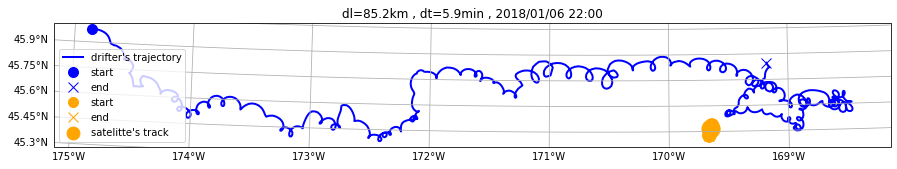

In [16]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection=ccrs.Orthographic(lon, lat))

land_feature = cfeature.LAND
#ax.add_feature(land_feature, zorder=2)

# aviso
#ax.contourf(do.box_lon, do.box_lat, slam, levels=30, cmap=cm.diff, transform=crs, label='aviso')
#ax.plot(_ds.box_lon[::10,::10], _ds.box_lat[::10,::10], "+", color="k", transform=crs)


# drifter
ax.plot(do["drifter_lon"], do["drifter_lat"], color="b", lw=2, transform=crs, label="drifter's trajectory")
ax.plot(do["drifter_lon"][0], do["drifter_lat"][0], "o", ms=10, color="b", transform=crs, label='start')
ax.plot(do["drifter_lon"][-1], do["drifter_lat"][-1], "x", ms=10, color="b", transform=crs, label='end')

#ax.plot(do["drifter_lon"], _dsm["drifter_lat"], 
#        "*", ms=20, color="g", lw=2, transform=crs, label='matchup point')

# altimetry
#ax.plot(_ds[asuff+"_lon"], _ds[asuff+"_lat"], color="orange", lw=2, transform=crs)
_sla = do["alti_sla"]
_sla = _sla - _sla.min()
ax.plot(do["alti_lon"][0], do["alti_lat"][0], "o", ms=10, color="orange", transform=crs, label='start')
ax.plot(do["alti_lon"][-1], do["alti_lat"][-1], "x", ms=10, color="orange", transform=crs,label='end')
ax.scatter(do["alti_lon"], do["alti_lat"], s=_sla*1000, color="orange", transform=crs, label= "satelitte's track")

gl = ax.gridlines(draw_labels=True, dms=False, 
             x_inline=False, y_inline=False, 
            )
gl.right_labels=False
gl.top_labels=False

ax.set_title(f"dl={dl/1e3:.1f}km , dt={dt/60:.1f}min , "+td.strftime("%Y/%m/%d %H:%M"))
plt.legend()

In [ ]:
cluster.close()